In [55]:
from PIL import Image
import numpy as np #pour les calculs 
from IPython.display import display #utilisé pour afficher les images directement dans le notebook
from math import sqrt, log10

In [2]:
def peinture(image,region,triplet):
    (x1,x2,y1,y2)=region
    for x in range(x1,x2):
        for y in range(y1,y2):
            image[x,y]=triplet

In [6]:
def moyenne(image,region):
    (x1,x2,y1,y2)=region
    n=(x2-x1)*(y2-y1) #nombre total de pixels
    rm,gm,bm=0,0,0
    for x in range(x1,x2):
        for y in range(y1,y2):
            (r,g,b)=image[x,y]
            rm,gm,bm=rm+r/n,gm+g/n,bm+b/n
    rmoy=int(round(rm)) #int(round()) permet d'avoir l'entier le plus proche
    gmoy=int(round(gm))
    bmoy=int(round(bm))
    return rmoy,gmoy,bmoy

In [10]:
def ecart_type(image,region):
    (x1,x2,y1,y2)=region
    rmoy,gmoy,bmoy=moyenne(image,region)
    n=(x2-x1)*(y2-y1) #nombre total de pixels
    rc,gc,bc=0,0,0
    for x in range(x1,x2):
        for y in range(y1,y2):
            (r,g,b)=image[x,y]
            rc+=(r**2)/n
            gc+=(g**2)/n
            bc+=(b**2)/n
    # à cause des arrondis ici, on peut parfois avoir par exemple ...
    #... rc < rmoy**2  lorsqu'ils sont très proches ...
    #... donc on met des valeurs absolues pour éviter des erreurs :
    re=round(sqrt(abs(rc-rmoy**2))) #on arrondit les valeurs pour ne pas traîner des décimales
    ge=round(sqrt(abs(gc-gmoy**2)))
    be=round(sqrt(abs(bc-bmoy**2)))
    return re,ge,be

In [17]:
def homogene(image,region,seuil):
    re,ge,be=ecart_type(image,region)
    return (re+ge+be)/3<=seuil

In [19]:
def div_rect(region):
    (x1,x2,y1,y2)=region
    if x2-x1>1 and y2-y1>1: #si la région est divisible en 4, en 2x2 :
        x=int((x2+x1)/2) #on prend la partie entière pour gérer les tailles impaires
        y=int((y2+y1)/2)
        rect1=(x1,x,y1,y)
        rect2=(x1,x,y,y2)
        rect3=(x,x2,y1,y)
        rect4=(x,x2,y,y2)
        return [rect1,rect2,rect3,rect4]
    elif x2-x1==1 and y2-y1>=4: #si la région est divisible en 4, en 1x4 :
        #on prend la partie entière pour gérer les tailles impaires :
        y0=int((y2+y1)/2)
        y01=int((y0+y1)/2)
        y02=int((y0+y2)/2)
        rect1=(x1,x2,y1,y01)
        rect2=(x1,x2,y01,y0)
        rect3=(x1,x2,y0,y02)
        rect4=(x1,x2,y02,y2)
        return [rect1,rect2,rect3,rect4] 
    elif y2-y1==1 and x2-x1>=4: #si la région est divisible en 4, en 4x1 :
        #on prend toujours la partie entière pour gérer les tailles impaires :
        x0=int((x2+x1)/2)
        x01=int((x0+x1)/2)
        x02=int((x0+x2)/2)
        rect1=(x1,x01,y1,y2)
        rect2=(x01,x0,y1,y2)
        rect3=(x0,x02,y1,y2)
        rect4=(x02,x2,y1,y2)
        return [rect1,rect2,rect3,rect4]

In [24]:
class Node:
    def __init__(self,region,enfants):
        self.region=region #représente la région définie par le noeud
        self.enfants=enfants #représente ses enfants (4 subdivisions) s'il en a
    def terminal(self,image,seuil):
        #le noeud est terminal s'il représente une région homogène ...
        # ... ou s'il n'est pas divisible en 4
        (x1,x2,y1,y2)=self.region
        if div_rect(self.region)==None: #si la région n'est pas divisible en 4
            return True
        else: #si la région est divisible en 4
            return homogene(image,self.region,seuil) #on vérifie si c'est homogène ou pas
    def __repr__(self):
        (x1,x2,y1,y2)=self.region
        #on suppose que le noeud est créé correctement, càd qu'on lui a ajouté des enfants s'il n'est pas terminal :
        if self.enfants==[]: #si le noeud n'a pas d'enfants (noeud terminal) :
            return 'Noeud terminal représentant la région ({},{},{},{})'.format(x1,x2,y1,y2)
        if self.enfants!=[]: #si le noeud a des enfants :
            a='Noeud définissant la région ({},{},{},{}) avec pour enfants :'.format(x1,x2,y1,y2)
            for n in self.enfants:
                (x1,x2,y1,y2)=n.region
                a=a+'\n- Région ({},{},{},{})'.format(x1,x2,y1,y2)
            return a

In [29]:
def division_arbre(image,region,seuil):
    if Node(region,[]).terminal(image,seuil): #si le noeud défini par la région est terminal :
        return Node(region,[]) #on retourne ce noeud
    else: #si le noeud n'est pas terminal :
        liste_rect=div_rect(region) #on crée les sous-régions
        enfants=[division_arbre(image,i,seuil) for i in liste_rect] #on fait l'appel récursif pour les sous-régions
        return Node(region,enfants) #on retourne le noeud avec les enfants créés à la ligne précédente

In [32]:
def peinture_arbre(noeud,image,seuil):
    if noeud.terminal(image,seuil): #si le noeud est terminal ...
        if homogene(image,noeud.region,seuil): # ... homogène
            triplet_moy=moyenne(image,noeud.region)
            peinture(image,noeud.region,triplet_moy) #on peint la région avec la couleur moyenne
        else:
        #permet d'arrêter la fonction si le noeud est terminal non homogène ...
        # ... pour éviter qu'il continue à s'appeler récursivement
            return None 
    else: #si le noeud n'est pas terminal
        for n in noeud.enfants:
            peinture_arbre(n,image,seuil) #on appelle la fonction pour les enfants

Pour enregistrer :

In [61]:
def image_compression(nom_fichier,seuil):
  extension=nom_fichier[-4:]
  prefixe=nom_fichier[:-4]
  nom_sortie=prefixe+'_compressed'+extension
  im=Image.open(nom_fichier)
  px=im.load()
  W,H=im.size
  N_e=division_arbre(px,(0,W,0,H),seuil)
  peinture_arbre(N_e,px,seuil)
  im.save(nom_sortie)

In [63]:
image_compression('Image9.bmp',30)

Visualisation du résultat

Image originale


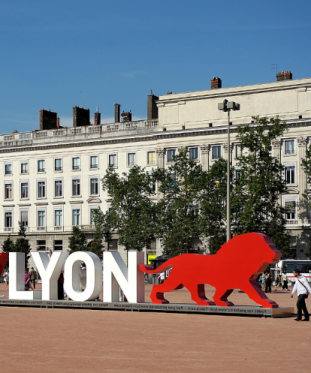

In [52]:
im_0=Image.open("Image9.bmp")
px_0=im_0.load()
print('Image originale')
display(im_0)

Seuil de 40


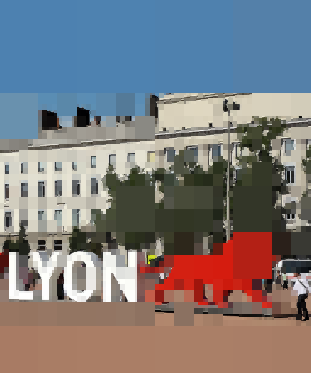

In [53]:
im=Image.open("Image9.bmp")
px=im.load()
W,H=im.size
N_e=division_arbre(px,(0,W,0,H),40)
peinture_arbre(N_e,px,40)
print('Seuil de 40')
display(im)

Seuil de 15


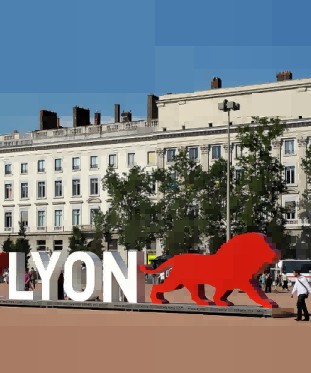

In [56]:
im_15=Image.open("Image9.bmp")
px_15=im_15.load()
N_15=division_arbre(px_15,(0,W,0,H),15)
peinture_arbre(N_15,px_15,15)
print('Seuil de 15')
display(im_15)
im_15.save('image_9_compressed.bmp')

Pour une autre image :

Image originale


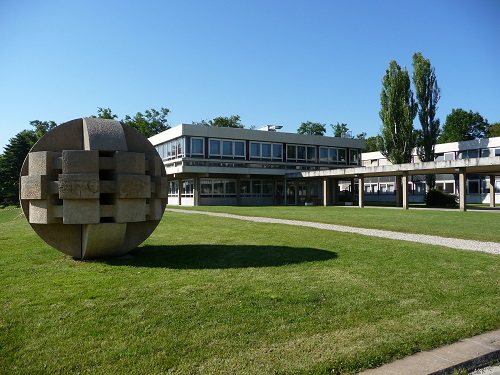

In [38]:
im_ecl=Image.open('ecl.jpg')
px_ecl=im_ecl.load()
print('Image originale')
display(im_ecl)

Seuil de 15


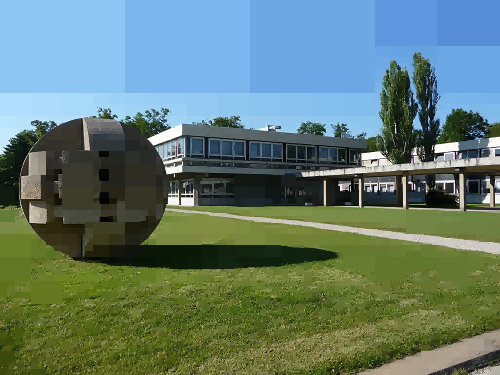

In [57]:
im_ecl_0=Image.open('ecl.jpg')
px_ecl_0=im_ecl_0.load()
W_ecl,H_ecl=im_ecl.size
N_ecl_0=division_arbre(px_ecl_0,(0,W_ecl,0,H_ecl),15)
peinture_arbre(N_ecl_0,px_ecl_0,15)
print('Seuil de 15')
display(im_ecl_0)
im_ecl_0.save('ecl_compressed.jpg')

Seuil de 30


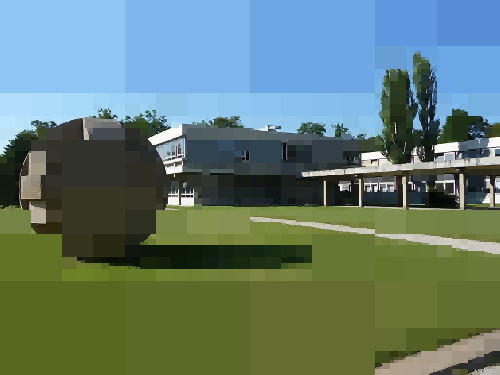

In [40]:
im_ecl_30=Image.open('ecl.jpg')
px_ecl_30=im_ecl_30.load()
W_ecl,H_ecl=im_ecl.size
N_ecl_30=division_arbre(px_ecl_30,(0,W_ecl,0,H_ecl),30)
peinture_arbre(N_ecl_30,px_ecl_30,30)
print('Seuil de 30')
display(im_ecl_30)